# Composing Losses with captum.optim

This notebook demonstrates how the loss functions in `captum.optim.loss` can be modified or combined to create interesting results.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torchvision.models import alexnet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = alexnet(pretrained=True).to(device)

In [2]:
# Helper function for visualization
def visualize(model, image, loss_fn, lr=0.025):
    transforms = torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        torch.nn.ReflectionPad2d(16),
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.CenterCrop((224,224)),
    )
    obj = opt.InputOptimization(model, loss_fn, image, transforms, lr=lr)
    history = obj.optimize(opt.optimization.n_steps(128))
    image().show()

## Negative Channel Visualizations

By taking negative `ChannelActivation`, we can generate visualizations that maximize activations in both positive and negative directions. In some cases, we can see that the visualizations are "oppposites" of each other.

/usr/local/lib/python3.8/site-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:848.)
  return super(Tensor, self).refine_names(names)


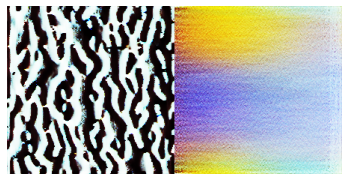

In [3]:
# Generate a visualization where the left and right images
# optimize losses in opposite directions.
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[1], 5, batch_index=0),
    -opt.loss.ChannelActivation(model.features[1], 5, batch_index=1),
])
visualize(model, image, loss_fn)

## Combining Neurons

We can also combine losses which will intuitively result in combinations of visualizations.

/Users/limsweekiat/Desktop/Projects/captum/captum/optim/_core/output_hook.py:39: UserWarning: Hook attached to ReLU(inplace=True) was called multiple times. As of 2019-11-22 please don't reuse nn.Modules in your models.
  warn(


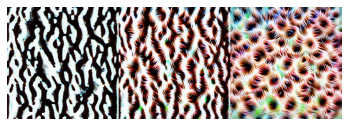

In [4]:
# Generate a visualization where the middle image is a combination
# of the left and right.
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[1], 5, 0),
    50*opt.loss.ChannelActivation(model.features[1], 5, 1),
    opt.loss.ChannelActivation(model.features[9], 8, 1),
    opt.loss.ChannelActivation(model.features[9], 8, 2),
])
visualize(model, image, loss_fn)